In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet tokenizers
!pip install --quiet sentencepiece
print("Done!")

Done!


In [1]:
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
print(torch.cuda.is_available())

True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv('Reddit_Data.csv')
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [5]:
df[df['clean_text'].isnull()].index

Index([148, 158694, 159443, 160560], dtype='int64')

In [6]:
df[df['category'].isnull()].index

Index([130448, 155642, 155698, 155770, 158693, 159442, 160559], dtype='int64')

In [7]:
df = df.drop([148, 158694, 159443, 160560,130448, 155642, 155698, 155770, 158693, 159442, 160559])
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


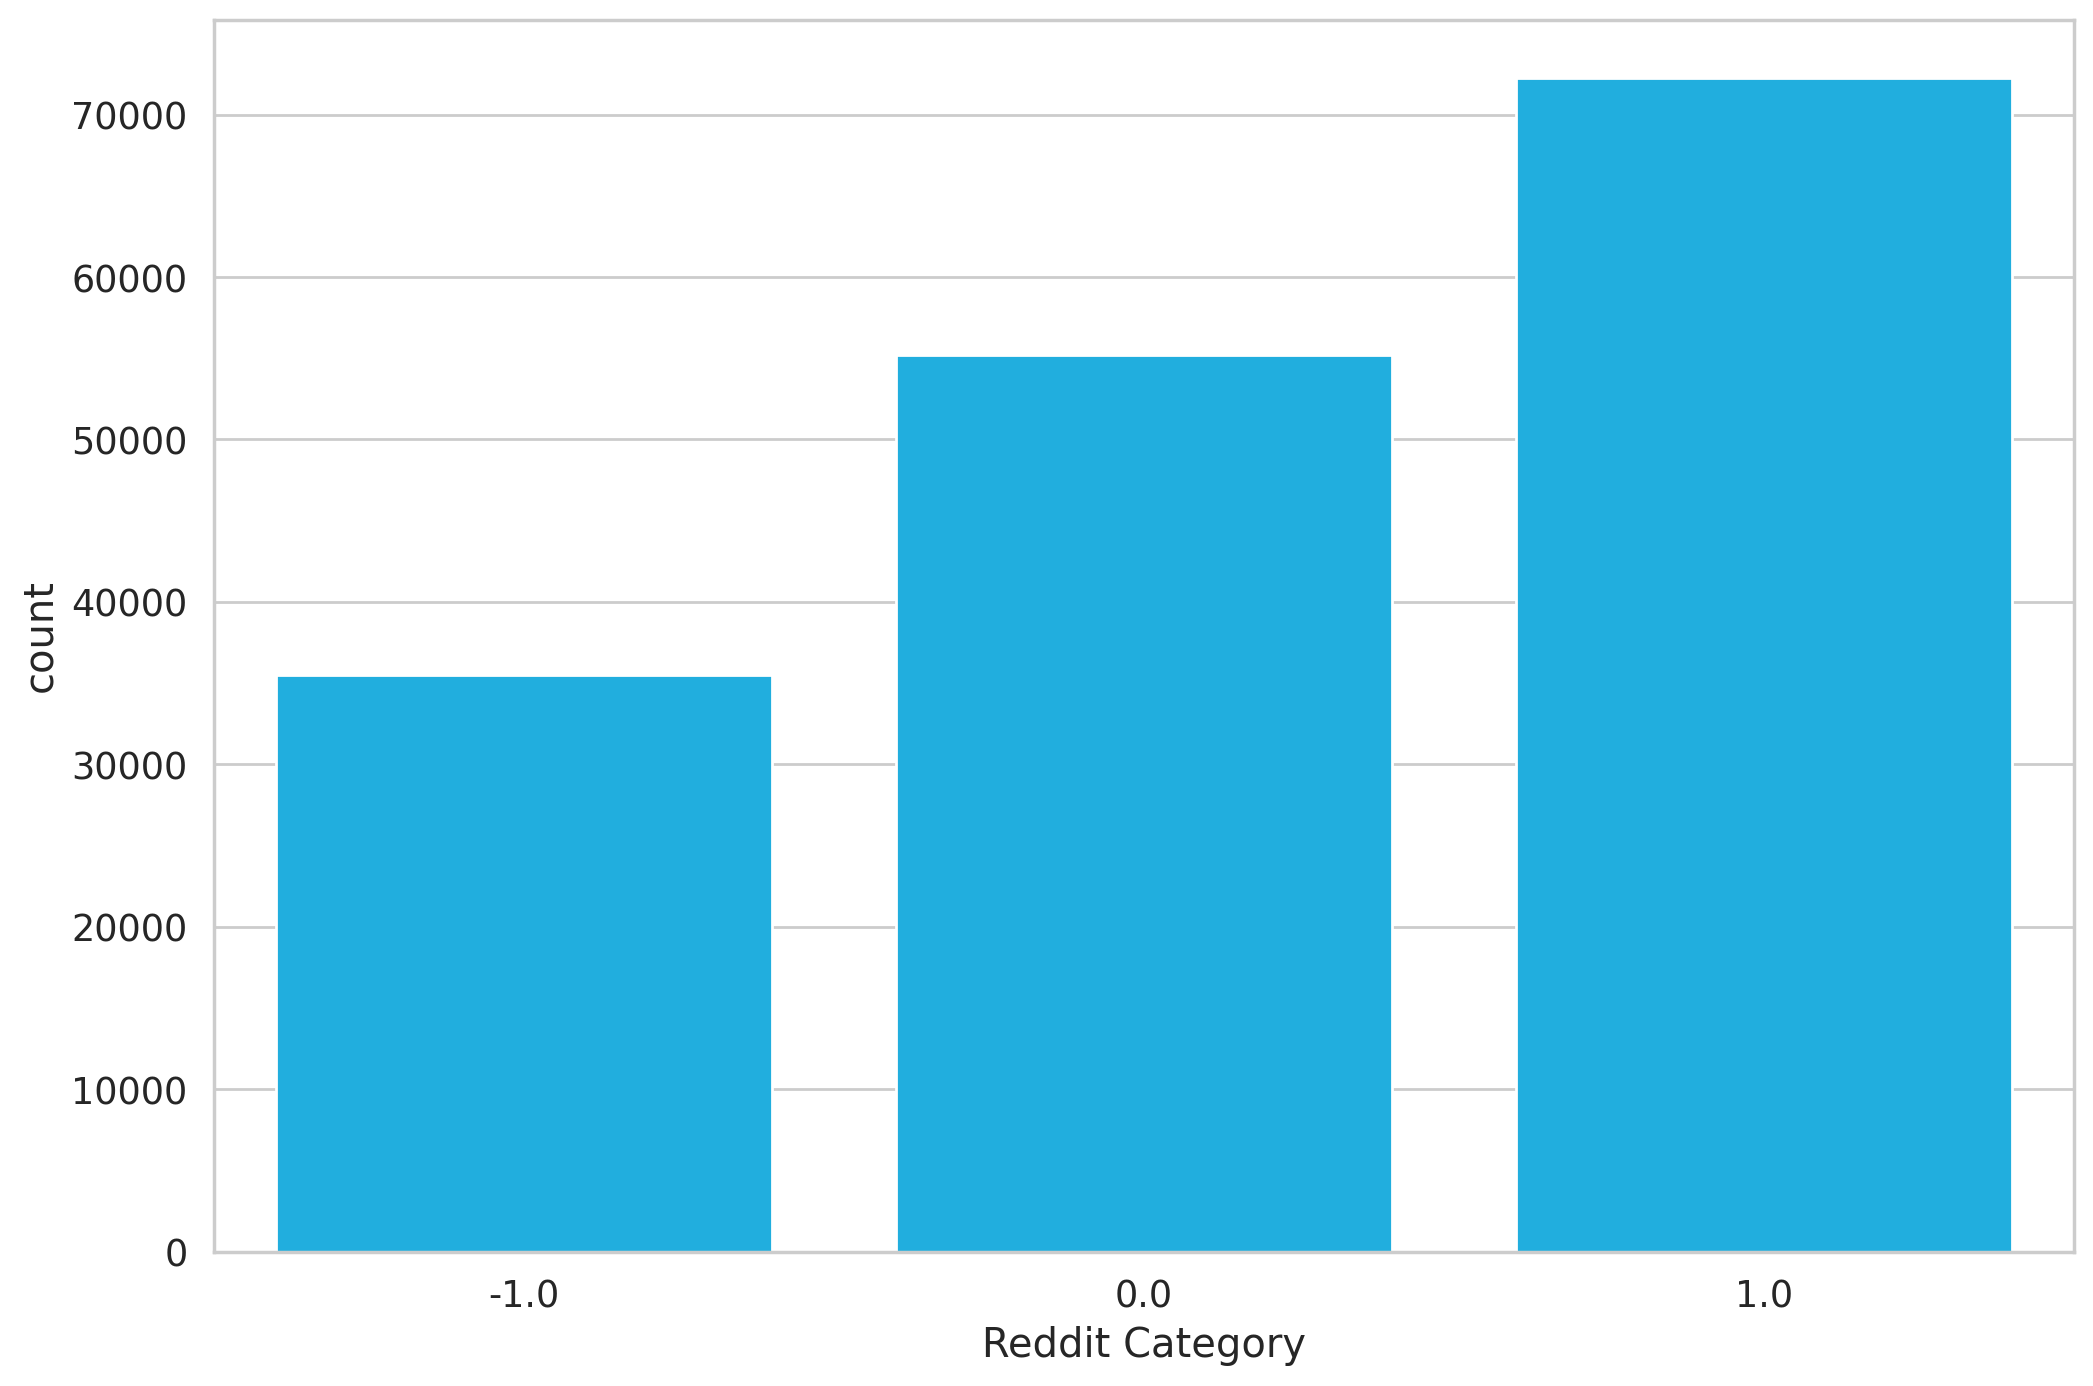

In [9]:
sns.countplot(x='category', data=df)
plt.xlabel('Reddit Category')
plt.show()

In [10]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == -1:
    return 0
  elif rating == 0 :
    return 1
  else:
    return 2
df['sentiment'] = df.category.apply(to_sentiment)

In [11]:
df.category.value_counts()

,count
category,
1.0,72249
0.0,55211
-1.0,35509


In [12]:
g = df.groupby('category')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df.category.value_counts()

<ipython-input-12-627fb5748f15>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


,count
category,
-1.0,35509
0.0,35509
1.0,35509


<ipython-input-13-783a29d24e8e>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


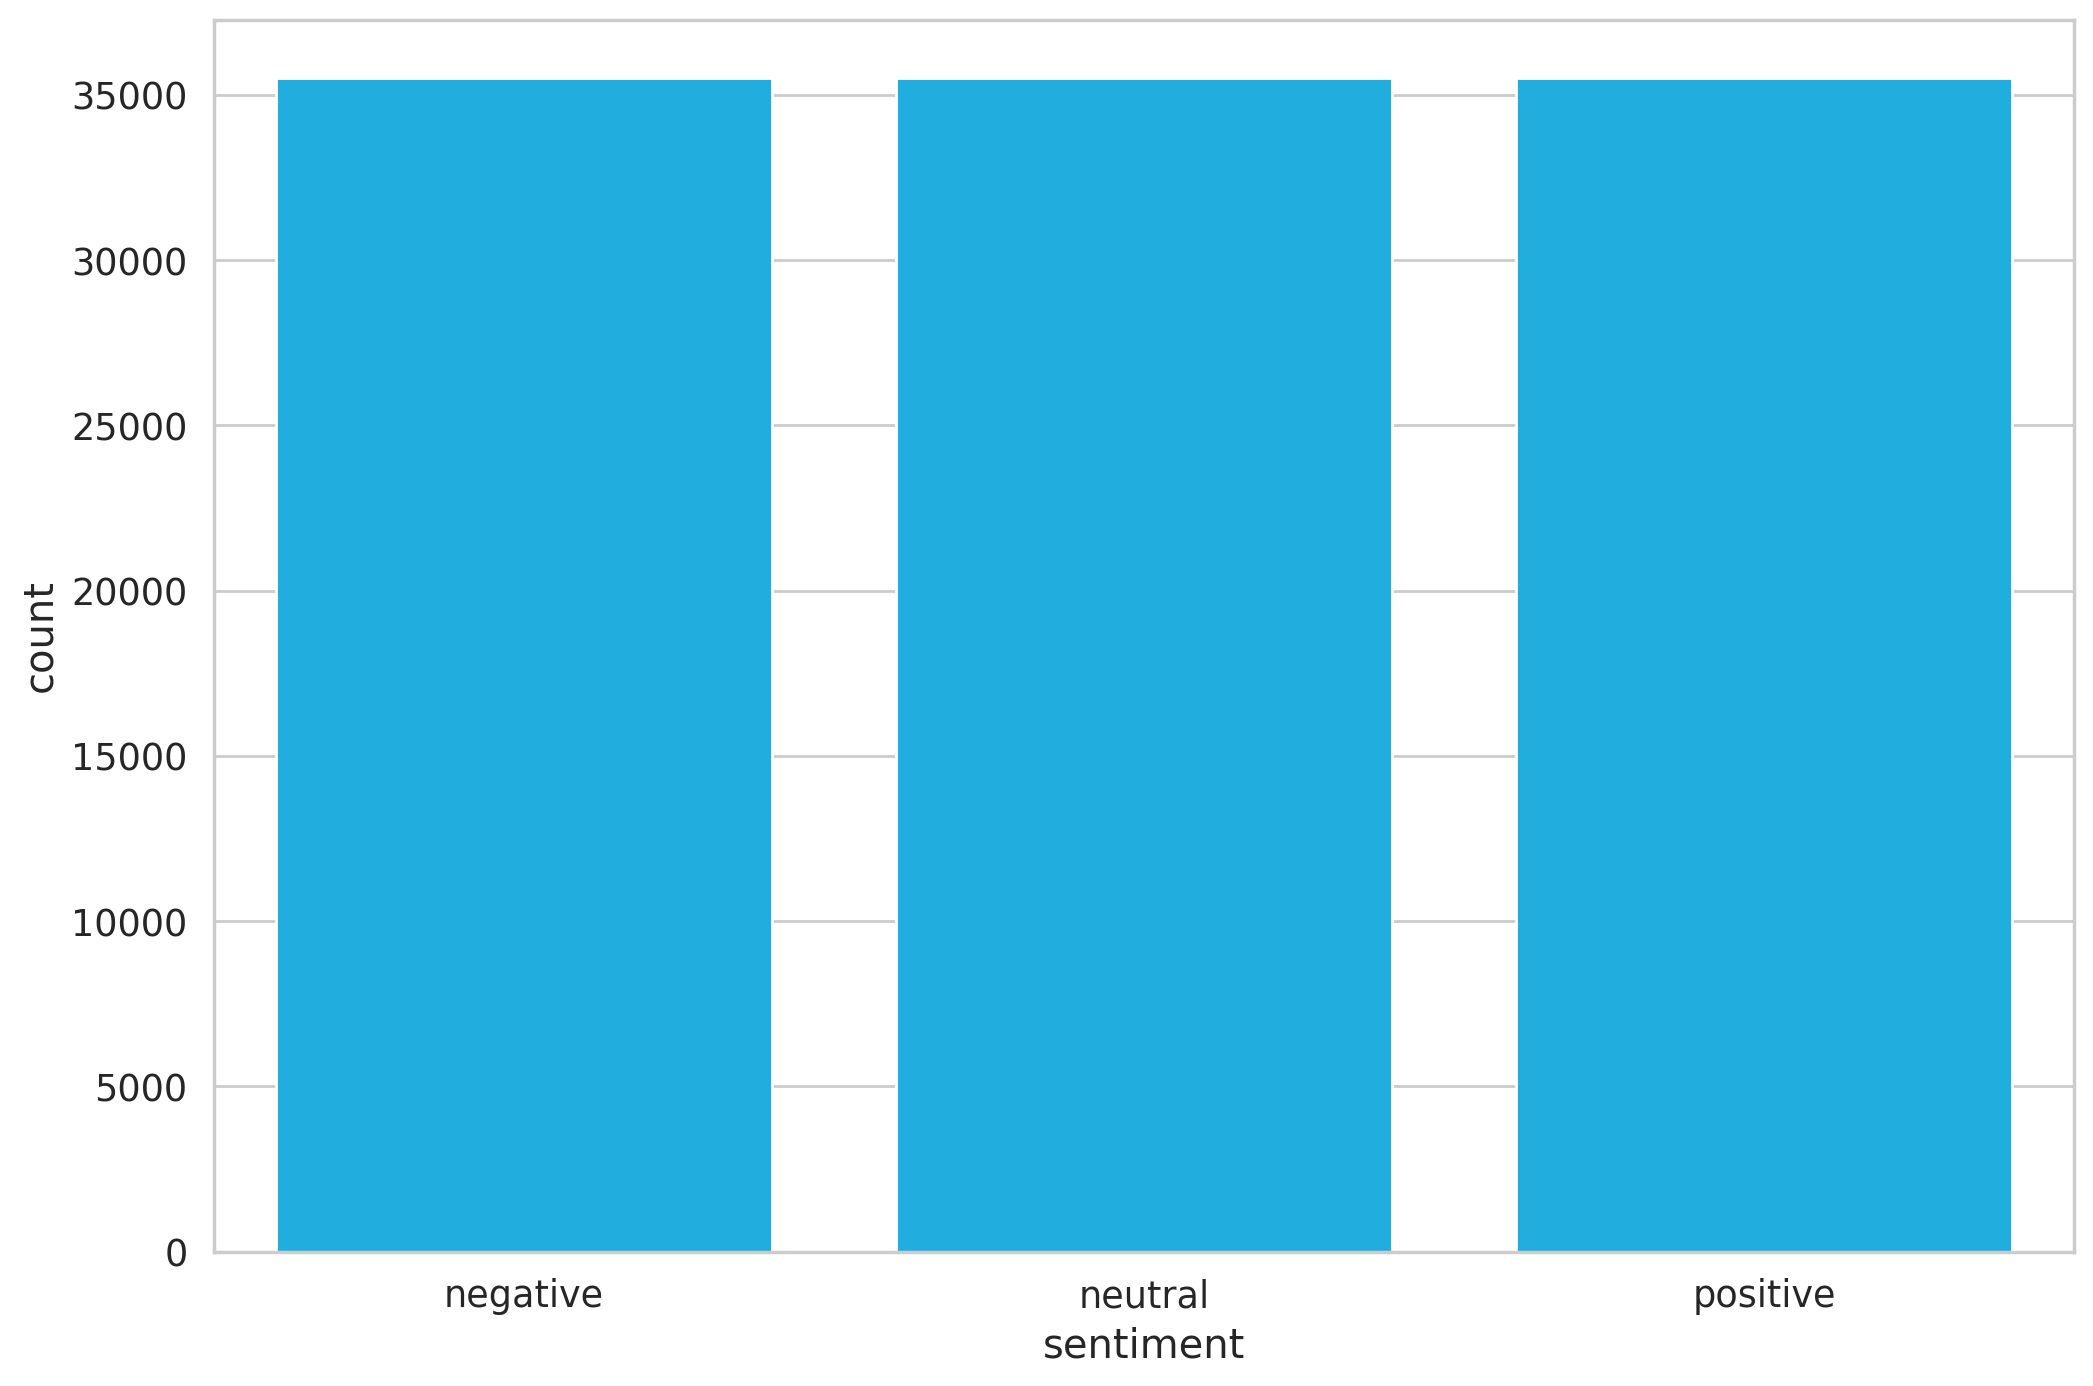

In [13]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(x='sentiment', data=df)
ax.set_xticklabels(class_names)
plt.show()

In [14]:
df = df.sample(frac=1)
df

clean_text  category  \
category                                                                      
-1.0     7255   why the above mentioned achievements the previ...      -1.0   
 0.0     21951  hoping that all the questions related for indi...       0.0   
         29217  already you have been used ace garner morality...       0.0   
 1.0     30856  both are wrong but there huge difference betwe...       1.0   
 0.0     9995   difference between mallya nirav modi case nira...       0.0   
...                                                           ...       ...   
         21861           namo merchandise owaisi brothers attack        0.0   
         26019  inspite repeated warnings from election commis...       0.0   
-1.0     2200   india’ narendra modi projects military might t...      -1.0   
 0.0     33628  what was the need for modi the time election v...       0.0   
-1.0     6447   unfortunate incidence which now affects our co...      -1.0   

                sentiment  
category                   
-1.0     7255           0  
 0.0     21951          1  
         29217          1  
 1.0     30856          2  
 0.0     9995           1  
...                   ...  
         21861          1  
         26019          1  
-1.0     2200           0  
 0.0     33628          1  
-1.0     6447           0  

[106527 rows x 3 columns]

In [15]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
MAX_LEN= 280
BATCH_SIZE = 64

In [32]:
class RedditSentimentDataset(Dataset):
  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)

  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [33]:
df_train, df_test = train_test_split(
  df,
  test_size=0.06,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [34]:
df_train.shape, df_test.shape, df_test.shape

((100135, 3), (3196, 3), (3196, 3))

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = RedditSentimentDataset(
    comments=df.clean_text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [36]:
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [37]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [38]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)
  def forward(self, input_ids, attention_mask):
    output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    pooled_output = output[1]
    output = self.drop(pooled_output)
    return self.out(output)
    return self.softmax(output)

In [39]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [40]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [41]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    optimizer.zero_grad()
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss = loss_fn(outputs, targets)
    _, preds = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    with torch.no_grad():
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.24860091975774057 accuracy 0.9112498127527838
Val loss 0.13370732817798853 accuracy 0.9568210262828536

Epoch 2/5
----------
Train loss 0.08950673068230883 accuracy 0.9737354571328707
Val loss 0.0982529741153121 accuracy 0.973404255319149

Epoch 3/5
----------
Train loss 0.05180157640332969 accuracy 0.9852099665451641
Val loss 0.09173603643663228 accuracy 0.9762202753441802

Epoch 4/5
----------


KeyboardInterrupt: 

In [44]:
print(best_accuracy)

tensor(0.9762, device='cuda:0', dtype=torch.float64)


Accuracy of 97.62% obtained and training terminated to prevent overfitting.